In [213]:
import codecs

import numpy as np
import pandas as pd

from __future__ import division

from math import exp, log

from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams

from string import punctuation

from collections import Counter
import itertools

from scipy.sparse import csr_matrix, hstack

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, roc_curve

from matplotlib import pyplot as plt

from lib.quality import hosmer

%matplotlib inline

pd.set_option('max_colwidth', 150)

stop_words = set(stopwords.words('english'))

In [2]:
# Load data
with codecs.open('../../datasets/kaggle/quora/train.csv') as fid:
    train_df = pd.read_csv(fid).fillna("nan")

with codecs.open('../../datasets/kaggle/quora/test.csv') as fid:
    test_df = pd.read_csv(fid).fillna("nan")

In [122]:
def tokenize(q):
    tokens = word_tokenize(q.lower().decode('utf8'))
    return [t for t in tokens if t not in stop_words and t not in punctuation]

# Compute factors: unigrams, bigrams and trigrams
def compute_ngrams_features(q1, q2):
    q1 = tokenize(q1)
    q2 = tokenize(q2)
    
    unigrams_q1 = set(i for i in ngrams(q1, 1))    
    unigrams_q2 = set(i for i in ngrams(q2, 1))
    unigrams_common = unigrams_q1 & unigrams_q2
    unigrams_differ = unigrams_q1 ^ unigrams_q2
    
    bigrams_q1 = set(i for i in ngrams(q1, 2))
    bigrams_q2 = set(i for i in ngrams(q2, 2))
    bigrams_common = bigrams_q1 & bigrams_q2
    bigrams_differ = bigrams_q1 ^ bigrams_q2
    
    trigrams_q1 = set(i for i in ngrams(q1, 3))
    trigrams_q2 = set(i for i in ngrams(q2, 3))
    trigrams_common = trigrams_q1 & trigrams_q2
    trigrams_differ = trigrams_q2 ^ trigrams_q2
    
    return unigrams_common | bigrams_common | trigrams_common, \
        unigrams_differ | bigrams_differ | trigrams_differ

In [123]:
train_df['fpos'], train_df['fneg'] = zip(*train_df.apply(lambda r: compute_ngrams_features(r['question1'], r['question2']), axis=1))

In [124]:
train_df[:3][['question1', 'question2', 'fpos', 'fneg']]

,question1,question2,fpos,fneg
0,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,"{(guide, invest, share), (invest, share, market), (guide, invest), (guide,), (share,), (market,), (invest,), (step, guide, invest), (step, guide),...","{(market, india), (india,)}"
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,"{(kohinoor, koh-i-noor, diamond), (kohinoor, koh-i-noor), (kohinoor,), (koh-i-noor, diamond), (diamond,), (koh-i-noor,)}","{(happen,), (stole,), (story,), (diamond, back), (government, stole), (story, kohinoor), (indian,), (would,), (indian, government), (stole, kohino..."
2,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,"{(internet,), (speed,)}","{(hacking,), (connection, using), (internet, speed), (speed, internet), (increase,), (connection,), (using,), (speed, increased), (vpn,), (dns,), ..."


In [125]:
# Feature stats 
feature_stats = Counter()
train_df['fpos'].apply(feature_stats.update);
train_df['fneg'].apply(feature_stats.update);

seq = itertools.count()
feature_map = {k: (next(seq), feature_stats[k]) for k in feature_stats}

In [127]:
# Create sparse features matrix
count = 0
col_idx = []
col_data = []
row_idx = []
for jrow, row in train_df.iterrows():
    row_idx.append(count)
    for f in row['fpos']:
        if f in feature_map:
            col_idx.append(feature_map[f][0])
            col_data.append(1)
            count += 1
    for f in row['fneg']:
        if f in feature_map:
            col_idx.append(feature_map[f][0])
            col_data.append(-1)
            count += 1
row_idx.append(count)
trainX = csr_matrix((col_data, col_idx, row_idx))

In [159]:
trainY = train_df['is_duplicate'].values

print trainY.size
print len(row_idx)

X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=4231)

train_ctr = sum(trainY) / len(trainY)
print 'Train CTR=%s' % train_ctr
print 'Train const Log Loss=%s' % log_loss(trainY, train_ctr + np.zeros(len(trainY)))
print - log(0.175) * 0.175 - (1 - 0.175) * log(1 - 0.175)

404290
404291
Train CTR=0.369197853026
Train const Log Loss=0.658527383984
0.463726439819


In [202]:
model = LogisticRegression(penalty='l2', solver='liblinear', 
                           max_iter=1000, C=1.1, tol=1.e-4, 
                           intercept_scaling=10,
                           class_weight={1: 0.46, 0: 1.32}
                          )

model.fit(X_train, y_train)

LogisticRegression(C=1.1, class_weight={0: 1.32, 1: 0.46}, dual=False,
          fit_intercept=True, intercept_scaling=10, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [203]:
p_train = [p[1] for p in model.predict_proba(X_train)]
print 'train log_loss=%s' % log_loss(y_train, p_train)
print 'train auc=%s' % roc_auc_score(y_train, p_train)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, p_train, pos_label=1)

train log_loss=0.208679246175
train auc=0.994573984778


test log_loss=0.399793834799
test auc=0.906438562345


(0, 1)

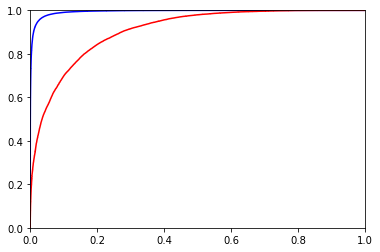

In [204]:
p_test = [p[1] for p in model.predict_proba(X_test)]
print 'test log_loss=%s' % log_loss(y_test, p_test)
print 'test auc=%s' % roc_auc_score(y_test, p_test)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, p_test, pos_label=1)
plt.plot(fpr_train, tpr_train, 'b-')
plt.plot(fpr_test, tpr_test, 'r-')
plt.xlim([0, 1])
plt.ylim([0, 1])

(0, 1)

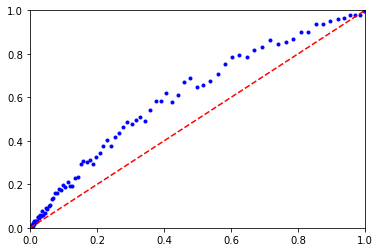

In [205]:
# Диагональные графики
avg_pred, avg_true = hosmer(y_test, p_test, nbins=100)
plt.plot(avg_pred, avg_true, 'b.', np.linspace(0, 1, 50), np.linspace(0, 1, 50), 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [207]:
test_df['fpos'], test_df['fneg'] = zip(*test_df.apply(lambda r: compute_ngrams_features(r['question1'], r['question2']), axis=1))

In [208]:
test_df[:5][['question1', 'question2', 'fpos', 'fneg']]

,question1,question2,fpos,fneg
0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?,"{(surface, pro, 4), (pro,), (4,), (surface, pro), (surface,), (pro, 4)}","{(ipad,), (core, m3), (choose, core), (microsoft,), (microsoft, choose), (compare, ipad), (home, surface), (m3, core), (home,), (choose,), (m3,), ..."
1,Should I have a hair transplant at age 24? How much would it cost?,How much cost does hair transplant require?,"{(transplant,), (much,), (hair,), (cost,), (hair, transplant)}","{(would, cost), (24,), (much, cost), (much, would), (age,), (cost, hair), (24, much), (require,), (transplant, age), (would,), (age, 24), (transpl..."
2,What but is the best way to send money from China to the US?,What you send money to China?,"{(send, money, china), (money, china), (send, money), (send,), (money,), (china,)}","{(way,), (best,), (best, way), (us,), (china, us), (way, send)}"
3,Which food not emulsifiers?,What foods fibre?,{},"{(fibre,), (emulsifiers,), (food, emulsifiers), (foods,), (food,), (foods, fibre)}"
4,"How ""aberystwyth"" start reading?",How their can I start reading?,"{(start, reading), (reading,), (start,)}","{(aberystwyth,), ('', start), ('',), (``, aberystwyth), (``,), (aberystwyth, '')}"


In [209]:
count = 0
col_idx = []
col_data = []
row_idx = []
for jrow, row in test_df.iterrows():
    row_idx.append(count)
    for f in row['fpos']:
        if f in feature_map:
            col_idx.append(feature_map[f][0])
            col_data.append(1)
            count += 1
    for f in row['fneg']:
        if f in feature_map:
            col_idx.append(feature_map[f][0])
            col_data.append(-1)
            count += 1
row_idx.append(count)
testX = csr_matrix((col_data, col_idx, row_idx))

In [210]:
#test_X = hstack((testX, csr_matrix((testX.shape[0], 1))))
p_test = [p[1] for p in model.predict_proba(testX)]

In [211]:
submission_name = "submission04"

submission = pd.DataFrame()
submission['test_id'] = test_df['test_id']
submission['is_duplicate'] = p_test
submission.to_csv(submission_name + '.csv', index=False)

In [72]:
len(p_test)

404290